# Notebook Initialisation

In [3]:
from os import getcwd, pardir
from os.path import join, abspath

# ! pip install jupyter_nbextensions_configurator jupyter_contrib_nbextensions
# ! jupyter contrib nbextension install
# ! jupyter nbextension install --py fileupload 
# ! jupyter nbextension enable --py fileupload
# ! jupyter nbextension install --py widgetsnbextension 
# ! jupyter nbextension enable --py widgetsnbextension
# ! jupyter nbextensions_configurator enable
# ! jupyter nbextension enable codefolding/main
# ! jupyter nbextension enable toc2/main

! jupyter nbextension enable --py --sys-prefix widgetsnbextension
# init_notebook_mode(connected=True)

## Get Root Directory
rootDirectory = abspath(join(abspath(join(getcwd(), pardir)), pardir))

# `do not disturb` mode
import warnings                                  
warnings.filterwarnings('ignore')

## Create a button that hides cells
from IPython.display import HTML

HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
            $('div.input').show();
        } else {
            $('div.input').hide();
        }
        code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Data Load 

In [4]:
from test_utils import *

testsDir = join(rootDirectory, 'smartcitizen-iscape-tests')

def loadButton(b):
    frequency = frequency_text.value + frequency_drop.value
    readings_selected = loadTest(frequency)
    
    for key in readings_selected.keys():
        try:
            readings[key] = dict()
            readings[key] = readings_selected[key]
        except NameError:
            global readings
            readings = dict()
            readings[key] = readings_selected[key]
    

def clearButton(b):
    
    global readings
    clearTests()
    readings = {}

display(widgets.HTML('<hr><h4>Import Local Tests</h4>'))

tests = getTests(testsDir)
interact(selectTests,
         x = widgets.SelectMultiple(options=tests, 
                           selected_labels = selectedTests, 
                           layout=widgets.Layout(width='700px')))

loadB = widgets.Button(description='Load Local Tests')
loadB.on_click(loadButton)

frequency_text = widgets.Text(description = 'Frequency',
                              value = '1',
                              layout = widgets.Layout(width='300px'))
frequency_drop = widgets.Dropdown(options = ['H', 'Min', 'S'],
                                  value = 'Min',
                                  description = '',
                                  layout = widgets.Layout(width='100px'))

frequency_box = widgets.HBox([frequency_text, frequency_drop])

resetB = widgets.Button(description='Clear Tests')
resetB.on_click(clearButton)

buttonBox = widgets.HBox([loadB, resetB])
totalBox = widgets.VBox([frequency_box, buttonBox])
display(totalBox)

------------------------------------------------------


## Test Load

Loading test **2018-10_INT_TEST_TEMP_CHARGE_CORRECTION_LEARNING** performed from 2018-11-06 to 2018-11-09

Test performed with commit ****

<hr />
<p><strong>Comment:</strong> 
Test for checking temperature of external and internal SHT31 with the Charger at 98 to 100% charging rate.
Two cases for correction learning of <strong>only the charging</strong></p>

### KIT

#### NOPM_042

Kit **NOPM_042** located **Europe/Madrid**

Kit **NOPM_042** has been loaded

#### PM_008

Kit **PM_008** located **Europe/Madrid**

Kit **PM_008** has been loaded

------------------------------------------------------


# Correction

In [2]:
from signal_utils import detect_peak, count_peak
from formula_utils import exponential_func, evaluate
from scipy.stats.stats import linregress   

def correct_charging(dataframe, params, plots = False):
    slope_exp_charging, intercept_exp_charging, max_value_charging, slope_exp_discharging, intercept_exp_discharging, max_value_discharging, slope_lin, intercept_lin = params
    
    # Prepare dataframe
    if plots:
        figure = plot.figure(figsize=(16,6))
        plot.plot(dataframe.index, dataframe['COUNTER_CHARGING'], label = 'COUNTER')
        plot.grid(True)
        plot.ylabel('COUNTER')
        plot.xlabel('TIME')
        plot.legend(loc='best')
    
        figure = plot.figure(figsize=(16,6))
        plot.plot(dataframe.index, dataframe['TRANSITION_CHARGING'], label = 'TRANSITION_CHARGING')
        plot.grid(True)
        plot.ylabel('PEAKS')
        plot.xlabel('TIME')
        plot.legend(loc='best')
    
    # Get the values
    batt_chg_rate = dataframe['BATT_CHG_RATE'].values
    counter_charging = dataframe['COUNTER_CHARGING'].values
    charging = dataframe['CHARGING'].values
    temperature = dataframe['TEMP'].values
    
    # initialise stuff
    diff_temp = np.zeros(len(dataframe.index))
    last_value_charging = 0
    last_value_discharging = 0
    
    for index_value in range(len(dataframe.index)):
        if index_value == 0: 
            diff_temp[index_value] = 0
        else:
            if charging[index_value]:
                # diff_temp[index_value] = (batt_chg_rate[index_value]*slope_lin + intercept_lin)*(1-max_value_charging*exponential_func(counter_charging[index_value], np.exp(intercept_exp_charging), slope_exp_charging, 0))
                diff_temp[index_value] = max_value_charging*(batt_chg_rate[index_value]*slope_lin + intercept_lin)*(1-np.exp(slope_exp_charging*counter_charging[index_value]+intercept_exp_discharging))
                last_value_charging = diff_temp[index_value]
            else:
                # diff_temp[index_value] = (intercept_exp_discharging - exponential_func(counter_charging[index_value], -(last_value_charging-intercept_exp_discharging), slope_exp_discharging, 0))
                # diff_temp[index_value] = last_value_charging-max_value_discharging*(1-exponential_func(counter_charging[index_value], np.exp(intercept_exp_discharging), slope_exp_discharging, 0))
                diff_temp[index_value] = last_value_charging-max_value_discharging*(1-np.exp(counter_charging[index_value]*slope_exp_discharging + intercept_exp_discharging))
                last_value_discharging = diff_temp[index_value]
    print 'Last values:', last_value_charging, last_value_discharging
    print 'Max values', max_value_charging, max_value_discharging
    return diff_temp

def find_charges(dataframe):
    dataframe['CHARGING'] = dataframe.loc[:,'BATT_CHG_RATE'] > 0
    dataframe['TRANSITION_CHARGING'] = detect_peak(dataframe['CHARGING'])
    list_charg = list(np.where(dataframe['TRANSITION_CHARGING'] == 1)[0])
    list_discharg = list(np.where(dataframe['TRANSITION_CHARGING'] == -1)[0])
    
    list_charging = dataframe.iloc[list_charg].index.tolist()
    list_discharging = dataframe.iloc[list_discharg].index.tolist()
    list_index = zip(list_charging, list_discharging)
    
    return list_index

def learn_charging(dataframe, charge_period, discharge_period, params, freq = '1Min'):
    _, _, _, _, _, _, slope_lin, intercept_lin = params

    ## EXPONENTIAL REGRESSION OF CHARGE PERIOD
    dataframe_up = dataframe[dataframe.index < charge_period[1]]
    dataframe_up = dataframe_up.resample(freq).bfill()
    
    dataframe_up['DIFF_TEMP'] /= (dataframe_up['BATT_CHG_RATE']*slope_lin + intercept_lin)
    max_value_up = max((dataframe_up['DIFF_TEMP']))
    index_max = dataframe_up['DIFF_TEMP'].argmax()
    max_value_up += 0.1
    dataframe_up = dataframe_up[dataframe_up.index < index_max]
    dataframe_up['LOG_DIFF_OVER_1'] = np.log(1 - dataframe_up['DIFF_TEMP']/max_value_up)
    
    ## Fit with y = Ae^(Bx) -> logy = logA + Bx
    logy_up = dataframe_up['LOG_DIFF_OVER_1'].values
    slope_exp_charging, intercept_exp_charging, _, _, _ = linregress(dataframe_up['COUNTER_CHARGING'].values, logy_up)
    
    ## EXPONENTIAL REGRESSION OF DISCHARGE PERIOD
    dataframe_down = dataframe[dataframe.index > discharge_period[0]]
    dataframe_down = dataframe_down[dataframe_down.index < discharge_period[1]]
    dataframe_down = dataframe_down.resample(freq).bfill()
    dataframe_down['DIFF_TEMP'] = -(dataframe_down['DIFF_TEMP']-max((dataframe_down['DIFF_TEMP'])))
    max_value_down = max((dataframe_down['DIFF_TEMP'])) + 0.1
    
    dataframe_down['LOG_DIFF_OVER_1'] = np.log(1 - dataframe_down['DIFF_TEMP']/max_value_down)
    
    ## Fit with y = Ae^(Bx) -> logy = logA + Bx
    logy_down = dataframe_down['LOG_DIFF_OVER_1'].values
    slope_exp_discharging, intercept_exp_discharging, _, _, _ = linregress(dataframe_down['COUNTER_CHARGING'].values, logy_down)
    
    params = [slope_exp_charging, intercept_exp_charging, max_value_up, slope_exp_discharging, intercept_exp_discharging, max_value_down, slope_lin, intercept_lin]
    return params

## First test

In [17]:
from os.path import join
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plot

from signal_utils import find_closest
%matplotlib inline

from IPython.display import display, clear_output, Markdown

freq = '1Min'

## Only for now
test_name = '2018-10_INT_TEST_TEMP_CHARGE_CORRECTION_LEARNING'
# device = 'NOPM_042'
device = 'PM_008'

filename = device

_data = readings[test_name]['devices'][device]['data']
_cols = _data.columns
index = _data.index
print _cols

imputer = SimpleImputer(strategy='median')
imputer.fit(_data)
test = imputer.transform(_data)
print test.shape

test_data = pd.DataFrame(imputer.transform(_data), columns = _cols)
test_data.index = index
test_data.drop_duplicates(inplace=True)

test_data = test_data.resample(freq, convention = 'start').bfill()

display(test_data.head(5))

# Initialise Parameters
params = [-0.019382759497426454, -0.10731879461860494, 1.8704647075397753, 0.08455507725845345, -0.022859087352155583, 0.6999999999999978, 0.001057923304, 0.0]
params_LUT = list()
params_LUTx = np.arange(0,105,5)
for item in params_LUTx:
    params_LUT.append([item, params])

params_LUT[find_closest(params_LUTx, 95)][1] = [-0.3239134009527317, 0.4703058536060254, 0.7089833739792859, 0.054044664848073055, -0.019089957658372403, 0.3899999999999991, 0.001057923304, 0.0]
params_LUT[find_closest(params_LUTx, 100)][1] = [-0.3239134009527317, 0.4703058536060254, 0.7089833739792859, 0.054044664848073055, -0.019089957658372403, 0.3899999999999991, 0.001057923304, 0.0]

test_data_func = test_data.loc[:,('TEMP', 'BATT_CHG_RATE', 'BATT')]
test_data_func['REGRESSED_DIFF_TEMP'] = 0
test_data_func['CHARGING'] = test_data_func.loc[:,'BATT_CHG_RATE'] > 0
test_data_func['TRANSITION_CHARGING'] = detect_peak(test_data_func['CHARGING'])
test_data_func['COUNTER_CHARGING'] = count_peak(test_data_func['CHARGING'], True, True, test_data_func['CHARGING'][0])
    
# test_data_func = test_data_func.resample('1Min').bfill()
display(test_data_func.head(5))

Index([u'BATT', u'BATT_CHG_RATE', u'LIGHT', u'TEMP', u'HUM', u'NOISE_A',
       u'PRESS', u'PM_1', u'PM_25', u'PM_10'],
      dtype='object')
(3890, 10)


,BATT,BATT_CHG_RATE,LIGHT,TEMP,HUM,NOISE_A,PRESS,PM_1,PM_25,PM_10
Time,,,,,,,,,,
2018-11-09 17:45:00+01:00,100.0,378.0,164.89,26.95,49.70,53.49,101.21,3.0,5.0,5.0
2018-11-09 17:46:00+01:00,100.0,349.0,195.50,27.01,41.52,54.13,101.19,6.0,9.0,10.0
2018-11-09 17:47:00+01:00,100.0,335.0,193.01,27.69,41.27,54.03,101.18,7.0,10.0,10.0
2018-11-09 17:48:00+01:00,100.0,323.0,193.07,28.20,39.83,46.39,101.17,7.0,10.0,10.0
2018-11-09 17:49:00+01:00,100.0,312.0,183.09,28.51,39.73,53.92,101.17,6.0,8.0,8.0


,TEMP,BATT_CHG_RATE,BATT,REGRESSED_DIFF_TEMP,CHARGING,TRANSITION_CHARGING,COUNTER_CHARGING
Time,,,,,,,
2018-11-09 17:45:00+01:00,26.95,378.0,100.0,0,True,1.0,0.0
2018-11-09 17:46:00+01:00,27.01,349.0,100.0,0,True,0.0,1.0
2018-11-09 17:47:00+01:00,27.69,335.0,100.0,0,True,0.0,2.0
2018-11-09 17:48:00+01:00,28.20,323.0,100.0,0,True,0.0,3.0
2018-11-09 17:49:00+01:00,28.51,312.0,100.0,0,True,0.0,4.0


1Min
Initial Battery: 100.0
Initial Battery: 100.0
Initial Battery: 98.0
Last values: 0.1543418390848142 -0.1191368532369233
Max values 0.708983373979 0.39
Initial Battery: 98.0
Last values: 0.24541263141674716 -0.06469787753862558
Max values 1.16773278038 0.44
Initial Battery: 98.0
Last values: 0.29712388861158445 -0.061866108448154156
Max values 1.41018531089 0.498
Initial Battery: 98.0
Last values: 0.3365791906578666 -0.029153016578424507
Max values 1.59565701414 0.5084
Initial Battery: 98.0
Last values: 0.3517671563197615 -0.013099164177215294
Max values 1.71461611999 0.50272
Initial Battery: 98.0
Last values: 0.35026613665460704 -0.038784139367446735
Max values 1.6837867315 0.538176
Initial Battery: 98.0
Last values: 0.37305097641264157 -0.029758920012640633
Max values 1.82335605733 0.5545408
Initial Battery: 98.0
Last values: 0.40530837040967893 -0.01126682980637056
Max values 2.00838909882 0.56563264
Initial Battery: 99.0
Last values: 0.4345676202021643 -0.024899963573334183
Max

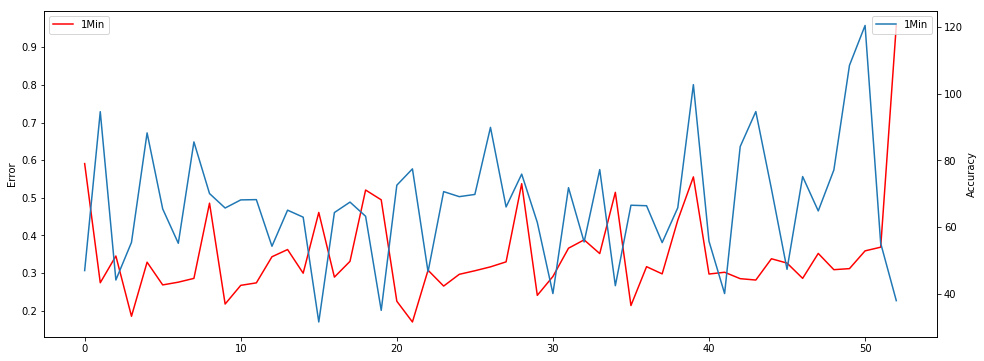

In [18]:
charges = (find_charges(test_data_func))
cool_down_period = 1360
dict_errors = dict()
dict_accuracies = dict()

freq_list = ['1Min']
fig, ax3 = plot.subplots(figsize=(16,6))
ax4 = ax3.twinx()
for frequency_resample in freq_list:
    dict_errors[frequency_resample] = list()
    dict_accuracies[frequency_resample] = list()
    print frequency_resample
    
    for item in charges:
        # print 'Calculating range from {} to {}'.format(item[0], item[1])
        charge_period = item
        discharge_period = (item[1], item[1] + pd.DateOffset(seconds = cool_down_period))
        
        test_data_trim = test_data_func[test_data_func.index > item[0]]
        test_data_trim = test_data_trim[test_data_trim.index < item[1] + pd.DateOffset(seconds = cool_down_period)]
        batt_init = test_data_trim['BATT'][0]
        charge_init = test_data_trim['BATT_CHG_RATE'][0]
        print 'Initial Battery:', batt_init
        if batt_init < 100:
            real_temp = test_data_trim.loc[test_data_trim.index[0],'TEMP']
            test_data_trim['DIFF_TEMP'] = test_data_trim.loc[:,'TEMP'] - real_temp
        
            # Correct charging
            params = params_LUT[find_closest(params_LUTx, batt_init)][1]
            test_data_trim['REGRESSED_DIFF_TEMP'] = correct_charging(test_data_trim, params, False)
            
            # Params learning
            params_new = learn_charging(test_data_trim, charge_period, discharge_period, params, frequency_resample)
            # print params_new
            alpha_new = 0.2
            params = [item[0]*alpha_new + item[1]*(1-alpha_new) for item in zip(params_new, params)]
            params_LUT[find_closest(params_LUTx, batt_init)][1] = params
            
            max_error, accuracy = evaluate(test_data_trim['REGRESSED_DIFF_TEMP'], test_data_trim['DIFF_TEMP'])
            dict_errors[frequency_resample].append(max_error)
            dict_accuracies[frequency_resample].append(accuracy)
            
            # fig, ax1 = plot.subplots()
            # ax1.plot(test_data_trim['DIFF_TEMP'])
            # ax1.plot(test_data_trim['REGRESSED_DIFF_TEMP'], 'b', label = 'model')
            # ax1.set_ylabel('TEMP', color='b')
            # ax1.axis('tight')
            # ax1.tick_params(axis='y', labelcolor='b')
            # ax1.get_yaxis().set_label_coords(-0.1,0.5)
            # ax2 = ax1.twinx()
            # ax2.plot(test_data_trim['CHARGING'], 'g')
            # ax2.set_ylabel('CHARGING', color='g')
            # ax2.axis('tight')
            # ax2.tick_params(axis='y', labelcolor='g')
            # ax2.spines['right'].set_position(('outward', 0))  
            # ax3 = ax1.twinx()
            # ax3.plot(test_data_trim['BATT_CHG_RATE'], 'r', alpha = 0.5)
            # ax3.set_ylabel('BATT_CHG_RATE', color='r')
            # ax3.axis('tight')
            # ax3.tick_params(axis='y', labelcolor='r')
            # ax3.spines['right'].set_position(('outward', 60))    
            # axx = ax1.twinx()
            # axx.plot(test_data_trim['COUNTER_CHARGING'], 'k', alpha = 0.5)
            # axx.axis('tight')
            # axx.set_ylabel('COUNTER_CHARGING', color='k')
            # axx.tick_params(axis='y', labelcolor='k')
            # axx.spines['right'].set_position(('outward', 120))      
            # plot.show()
            
            test_data_func.loc[charge_period[0]:discharge_period[1], 'REGRESSED_DIFF_TEMP'] = test_data_trim['REGRESSED_DIFF_TEMP']
            test_data_func.loc[charge_period[0]:discharge_period[1], 'DIFF_TEMP'] = test_data_trim['DIFF_TEMP']
    
    # print '---------------'
    ax3.plot(dict_errors[frequency_resample], 'r', label = frequency_resample)
    ax4.plot(dict_accuracies[frequency_resample], label = frequency_resample)
    
    ax3.set_ylabel('Error')
    ax4.set_ylabel('Accuracy')
    ax3.legend(loc='best')
    ax4.legend(loc='best')
# print 'Merging everything together'
# test_data['REGRESSED_DIFF_TEMP'] = test_data_func['REGRESSED_DIFF_TEMP']

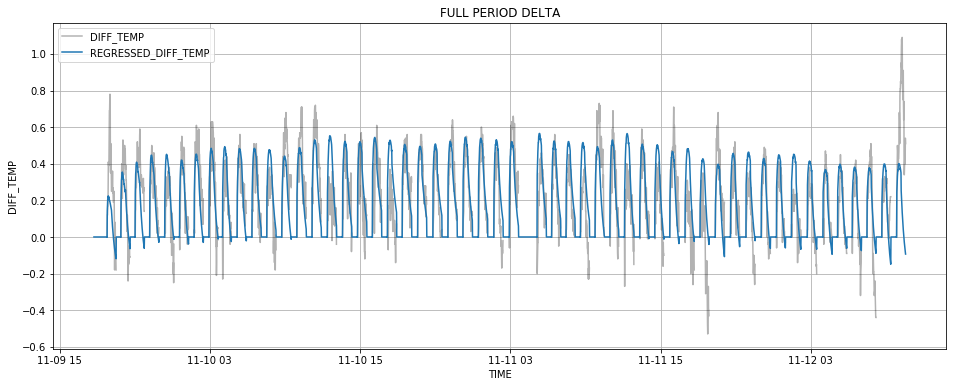

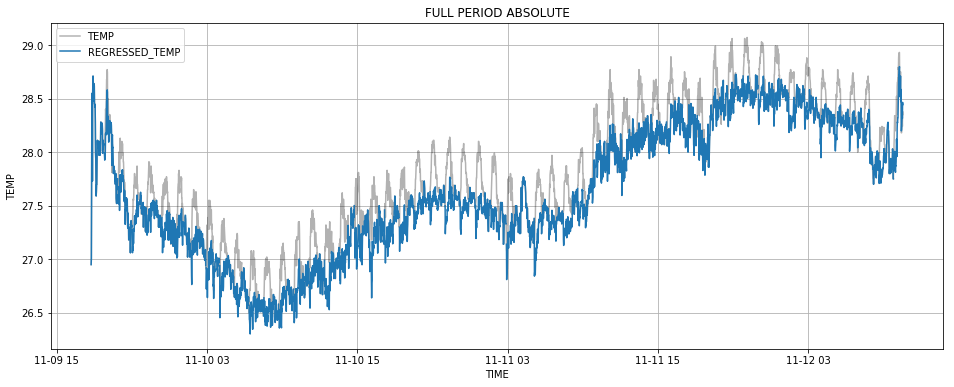

In [19]:
figure = plot.figure(figsize=(16,6))
plot.plot(test_data_func.index, test_data_func['DIFF_TEMP'], 'k', label= 'DIFF_TEMP', alpha = 0.3)
plot.plot(test_data_func.index, test_data_func['REGRESSED_DIFF_TEMP'], label= 'REGRESSED_DIFF_TEMP')
plot.title('FULL PERIOD DELTA')
plot.grid(True)
plot.ylabel('DIFF_TEMP')
plot.xlabel('TIME')
plot.legend(loc='best')
# plot.xlim(['2018-11-10 05:08:01+01:00', '2018-11-10 18:08:01+01:00'])

figure = plot.figure(figsize=(16,6))
plot.plot(test_data.index, test_data['TEMP'], 'k', label= 'TEMP', alpha = 0.3)
if 'EXT_TEMP' in test_data.columns:
    plot.plot(test_data.index, test_data['EXT_TEMP'], label= 'EXT_TEMP')
plot.plot(test_data_func.index, test_data_func['TEMP'] - test_data_func['REGRESSED_DIFF_TEMP'], label= 'REGRESSED_TEMP')
# plot.plot(test_data['COUNTER'], test_data['TEMP'] - test_data['REGRESSED_DIFF_TEMP']-test_2['EXT_TEMP'], label= 'ERROR')
plot.title('FULL PERIOD ABSOLUTE')
plot.grid(True)
plot.ylabel('TEMP')
plot.xlabel('TIME')
plot.legend(loc='best')
# plot.xlim(['2018-11-11 05:08:01+01:00', '2018-11-11 18:08:01+01:00'])

## Second Test

In [20]:
from os.path import join
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plot

from signal_utils import find_closest
%matplotlib inline

from IPython.display import display, clear_output, Markdown

freq = '1Min'

## Only for now
test_name = '2018-10_INT_TEST_TEMP_CHARGE_CORRECTION_LEARNING'
device = 'NOPM_042'
# device = 'PM_008'

filename = device

_data = readings[test_name]['devices'][device]['data']
_cols = _data.columns
index = _data.index
print _cols

imputer = SimpleImputer(strategy='median')
imputer.fit(_data)
test = imputer.transform(_data)
print test.shape

test_data = pd.DataFrame(imputer.transform(_data), columns = _cols)
test_data.index = index
test_data.drop_duplicates(inplace=True)

test_data = test_data.resample(freq, convention = 'start').bfill()

display(test_data.head(5))

# Initialise Parameters
params = [-0.019382759497426454, -0.10731879461860494, 1.8704647075397753, 0.08455507725845345, -0.022859087352155583, 0.6999999999999978, 0.001057923304, 0.0]
params_LUT = list()
params_LUTx = np.arange(0,105,5)
for item in params_LUTx:
    params_LUT.append([item, params])

params_LUT[find_closest(params_LUTx, 95)][1] = [-0.3239134009527317, 0.4703058536060254, 0.7089833739792859, 0.054044664848073055, -0.019089957658372403, 0.3899999999999991, 0.001057923304, 0.0]
params_LUT[find_closest(params_LUTx, 100)][1] = [-0.3239134009527317, 0.4703058536060254, 0.7089833739792859, 0.054044664848073055, -0.019089957658372403, 0.3899999999999991, 0.001057923304, 0.0]

test_data_func = test_data.loc[:,('TEMP', 'BATT_CHG_RATE', 'BATT')]
test_data_func['REGRESSED_DIFF_TEMP'] = 0
test_data_func['CHARGING'] = test_data_func.loc[:,'BATT_CHG_RATE'] > 0
test_data_func['TRANSITION_CHARGING'] = detect_peak(test_data_func['CHARGING'])
test_data_func['COUNTER_CHARGING'] = count_peak(test_data_func['CHARGING'], True, True, test_data_func['CHARGING'][0])
    
# test_data_func = test_data_func.resample('1Min').bfill()
display(test_data_func.head(5))

Index([u'BATT', u'BATT_CHG_RATE', u'EXT_HUM', u'EXT_TEMP', u'HUM', u'LIGHT',
       u'NOISE_A', u'TEMP'],
      dtype='object')
(8946, 8)


,BATT,BATT_CHG_RATE,EXT_HUM,EXT_TEMP,HUM,LIGHT,NOISE_A,TEMP
Time,,,,,,,,
2018-11-06 13:30:00+01:00,3.5,943.0,49.5535,23.3125,40.900,311.205,50.535,23.565
2018-11-06 13:31:00+01:00,4.5,944.0,49.9650,23.3060,41.295,338.585,50.755,23.735
2018-11-06 13:32:00+01:00,5.0,943.5,49.4870,23.2710,39.905,313.200,49.355,23.895
2018-11-06 13:33:00+01:00,6.0,944.0,49.3615,23.2710,39.560,323.820,50.985,24.005
2018-11-06 13:34:00+01:00,7.0,944.0,49.3825,23.2710,39.355,386.355,49.675,24.100


,TEMP,BATT_CHG_RATE,BATT,REGRESSED_DIFF_TEMP,CHARGING,TRANSITION_CHARGING,COUNTER_CHARGING
Time,,,,,,,
2018-11-06 13:30:00+01:00,23.565,943.0,3.5,0,True,1.0,0.0
2018-11-06 13:31:00+01:00,23.735,944.0,4.5,0,True,0.0,1.0
2018-11-06 13:32:00+01:00,23.895,943.5,5.0,0,True,0.0,2.0
2018-11-06 13:33:00+01:00,24.005,944.0,6.0,0,True,0.0,3.0
2018-11-06 13:34:00+01:00,24.100,944.0,7.0,0,True,0.0,4.0


1Min
Initial Battery: 4.5
Last values: 0.807767578448712 0.21425315536958822
Max values 1.87046470754 0.7
[-0.08803735952734022, -0.2199971679492747, 1.2052901140290695, 0.1135145165484115, -0.01660720221006695, 1.1399999999999992, 0.001057923304, 0.0]
Initial Battery: 22.0
Last values: 0.32183042225320585 -0.271684000825918
Max values 1.87046470754 0.7
[-0.004761198733112589, -0.1660911622801578, 3.259986402770432, 0.08921190899573701, -0.03192852767506582, 0.6449999999999981, 0.001057923304, 0.0]
Initial Battery: 99.0
Last values: 0.22692397465984113 -0.046554717661896367
Max values 0.708983373979 0.39
[-0.33020519743203924, 0.4422356653463666, 0.7579141650827366, 0.05773100513863823, -0.012379772354738416, 0.37999999999999756, 0.001057923304, 0.0]
Initial Battery: 100.0
Initial Battery: 100.0
Initial Battery: 100.0
---------------


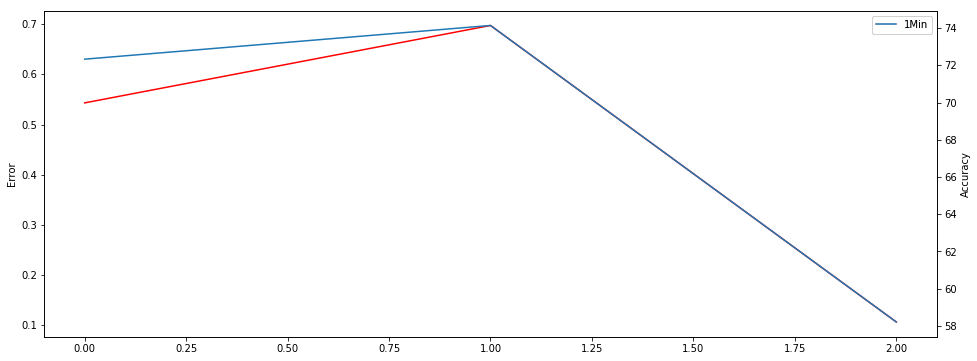

In [21]:
charges = (find_charges(test_data_func))
cool_down_period = 1360
dict_errors = dict()
dict_accuracies = dict()

freq_list = ['1Min']
fig, ax3 = plot.subplots(figsize=(16,6))
ax4 = ax3.twinx()
for frequency_resample in freq_list:
    dict_errors[frequency_resample] = list()
    dict_accuracies[frequency_resample] = list()
    print frequency_resample
    
    for item in charges:
        # print 'Calculating range from {} to {}'.format(item[0], item[1])
        charge_period = item
        discharge_period = (item[1], item[1] + pd.DateOffset(seconds = cool_down_period))
        
        test_data_trim = test_data_func[test_data_func.index > item[0]]
        test_data_trim = test_data_trim[test_data_trim.index < item[1] + pd.DateOffset(seconds = cool_down_period)]
        batt_init = test_data_trim['BATT'][0]
        charge_init = test_data_trim['BATT_CHG_RATE'][0]
        print 'Initial Battery:', batt_init
        if batt_init < 100:
            real_temp = test_data_trim.loc[test_data_trim.index[0],'TEMP']
            test_data_trim['DIFF_TEMP'] = test_data_trim.loc[:,'TEMP'] - real_temp
        
            # Correct charging
            params = params_LUT[find_closest(params_LUTx, batt_init)][1]
            test_data_trim['REGRESSED_DIFF_TEMP'] = correct_charging(test_data_trim, params, False)
            
            # Params learning
            params_new = learn_charging(test_data_trim, charge_period, discharge_period, params, frequency_resample)
            print params_new
            alpha_new = 0.2
            params = [item[0]*alpha_new + item[1]*(1-alpha_new) for item in zip(params_new, params)]
            params_LUT[find_closest(params_LUTx, batt_init)][1] = params
            
            max_error, accuracy = evaluate(test_data_trim['REGRESSED_DIFF_TEMP'], test_data_trim['DIFF_TEMP'])
            dict_errors[frequency_resample].append(max_error)
            dict_accuracies[frequency_resample].append(accuracy)
            
            # fig, ax1 = plot.subplots()
            # ax1.plot(test_data_trim['DIFF_TEMP'])
            # ax1.plot(test_data_trim['REGRESSED_DIFF_TEMP'], 'b', label = 'model')
            # ax1.set_ylabel('TEMP', color='b')
            # ax1.axis('tight')
            # ax1.tick_params(axis='y', labelcolor='b')
            # ax1.get_yaxis().set_label_coords(-0.1,0.5)
            # ax2 = ax1.twinx()
            # ax2.plot(test_data_trim['CHARGING'], 'g')
            # ax2.set_ylabel('CHARGING', color='g')
            # ax2.axis('tight')
            # ax2.tick_params(axis='y', labelcolor='g')
            # ax2.spines['right'].set_position(('outward', 0))  
            # ax3 = ax1.twinx()
            # ax3.plot(test_data_trim['BATT_CHG_RATE'], 'r', alpha = 0.5)
            # ax3.set_ylabel('BATT_CHG_RATE', color='r')
            # ax3.axis('tight')
            # ax3.tick_params(axis='y', labelcolor='r')
            # ax3.spines['right'].set_position(('outward', 60))    
            # axx = ax1.twinx()
            # axx.plot(test_data_trim['COUNTER_CHARGING'], 'k', alpha = 0.5)
            # axx.axis('tight')
            # axx.set_ylabel('COUNTER_CHARGING', color='k')
            # axx.tick_params(axis='y', labelcolor='k')
            # axx.spines['right'].set_position(('outward', 120))      
            # plot.show()
            
            test_data_func.loc[charge_period[0]:discharge_period[1], 'REGRESSED_DIFF_TEMP'] = test_data_trim['REGRESSED_DIFF_TEMP']
            test_data_func.loc[charge_period[0]:discharge_period[1], 'DIFF_TEMP'] = test_data_trim['DIFF_TEMP']
    
    print '---------------'
    ax3.plot(dict_errors[frequency_resample], 'r', label = frequency_resample)
    ax4.plot(dict_accuracies[frequency_resample], label = frequency_resample)
    
    ax3.set_ylabel('Error')
    ax4.set_ylabel('Accuracy')
    ax3.legend(loc='best')
    ax4.legend(loc='best')
# print 'Merging everything together'
# test_data['REGRESSED_DIFF_TEMP'] = test_data_func['REGRESSED_DIFF_TEMP']

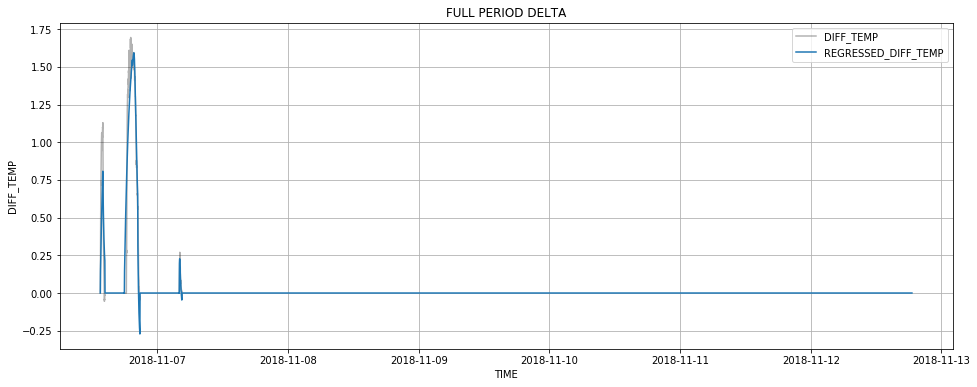

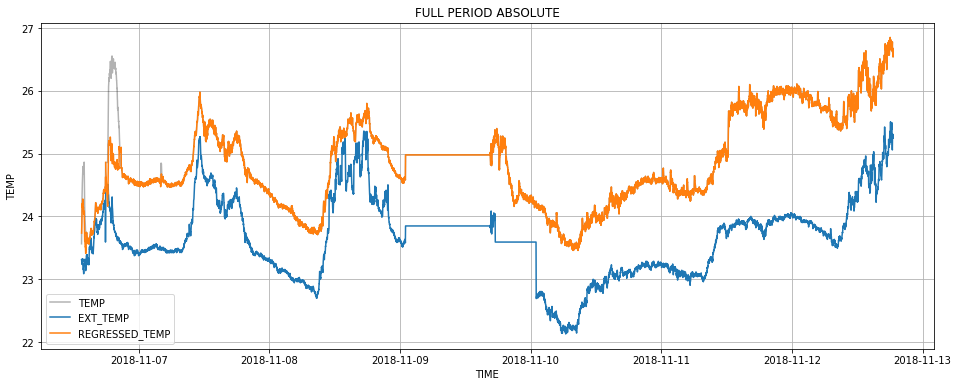

In [22]:
figure = plot.figure(figsize=(16,6))
plot.plot(test_data_func.index, test_data_func['DIFF_TEMP'], 'k', label= 'DIFF_TEMP', alpha = 0.3)
plot.plot(test_data_func.index, test_data_func['REGRESSED_DIFF_TEMP'], label= 'REGRESSED_DIFF_TEMP')
plot.title('FULL PERIOD DELTA')
plot.grid(True)
plot.ylabel('DIFF_TEMP')
plot.xlabel('TIME')
plot.legend(loc='best')
# plot.xlim(['2018-11-10 05:08:01+01:00', '2018-11-10 18:08:01+01:00'])

figure = plot.figure(figsize=(16,6))
plot.plot(test_data.index, test_data['TEMP'], 'k', label= 'TEMP', alpha = 0.3)
if 'EXT_TEMP' in test_data.columns:
    plot.plot(test_data.index, test_data['EXT_TEMP'], label= 'EXT_TEMP')
plot.plot(test_data_func.index, test_data_func['TEMP'] - test_data_func['REGRESSED_DIFF_TEMP'], label= 'REGRESSED_TEMP')
# plot.plot(test_data['COUNTER'], test_data['TEMP'] - test_data['REGRESSED_DIFF_TEMP']-test_2['EXT_TEMP'], label= 'ERROR')
plot.title('FULL PERIOD ABSOLUTE')
plot.grid(True)
plot.ylabel('TEMP')
plot.xlabel('TIME')
plot.legend(loc='best')
# plot.xlim(['2018-11-11 05:08:01+01:00', '2018-11-11 18:08:01+01:00'])